Code to demonstrate pytetrad_plus capabilities.

In [2]:
from pytetrad_plus import MyTetradSearch
from dgraph_flex import DgraphFlex
import semopy
import pprint as pp

In [3]:
# create  an instance o MyTetradSearch
ts = MyTetradSearch()

# set the data and knowledge files
data_file = 'pytetrad_plus/boston_data_raw.csv'
knowledge_file = 'pytetrad_plus/boston_prior.txt'


In [4]:
# read in the data
df = ts.read_csv(data_file)
df

,alcohol_bev,TIB,TST,PANAS_PA,PANAS_NA,worry_scale,PHQ9
0,1.0,9.00,7.333333,44.0,13.0,8.0,0.0
1,0.0,10.25,8.750000,40.0,12.0,14.0,0.0
2,1.0,8.50,7.166667,39.0,12.0,15.0,0.0
3,1.0,8.75,8.083333,39.0,12.0,12.0,0.0
4,1.0,8.25,6.666667,38.0,13.0,15.0,0.0
...,...,...,...,...,...,...,...
636,4.0,8.75,7.916667,29.0,12.0,17.0,3.0
637,4.0,8.50,7.666667,31.0,12.0,17.0,4.0
638,3.0,8.50,7.583333,33.0,13.0,17.0,3.0
639,3.0,9.00,8.166667,31.0,12.0,19.0,2.0


In [5]:
# add the lags, with a suffix of '_lag'
df_lag = ts.add_lag_columns(df, lag_stub='_lag')
df_lag

,alcohol_bev,TIB,TST,PANAS_PA,PANAS_NA,worry_scale,PHQ9,alcohol_bev_lag,TIB_lag,TST_lag,PANAS_PA_lag,PANAS_NA_lag,worry_scale_lag,PHQ9_lag
0,0.0,10.25,8.750000,40.0,12.0,14.0,0.0,1.0,9.00,7.333333,44.0,13.0,8.0,0.0
1,1.0,8.50,7.166667,39.0,12.0,15.0,0.0,0.0,10.25,8.750000,40.0,12.0,14.0,0.0
2,1.0,8.75,8.083333,39.0,12.0,12.0,0.0,1.0,8.50,7.166667,39.0,12.0,15.0,0.0
3,1.0,8.25,6.666667,38.0,13.0,15.0,0.0,1.0,8.75,8.083333,39.0,12.0,12.0,0.0
4,0.0,8.25,7.416667,37.0,12.0,16.0,0.0,1.0,8.25,6.666667,38.0,13.0,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,4.0,8.75,7.916667,29.0,12.0,17.0,3.0,6.0,7.00,6.166667,31.0,15.0,18.0,3.0
636,4.0,8.50,7.666667,31.0,12.0,17.0,4.0,4.0,8.75,7.916667,29.0,12.0,17.0,3.0
637,3.0,8.50,7.583333,33.0,13.0,17.0,3.0,4.0,8.50,7.666667,31.0,12.0,17.0,4.0
638,3.0,9.00,8.166667,31.0,12.0,19.0,2.0,3.0,8.50,7.583333,33.0,13.0,17.0,3.0


In [6]:
# standardize the data
df_lag_std = ts.standardize_df_cols(df_lag)
df_lag_std

,alcohol_bev,TIB,TST,PANAS_PA,PANAS_NA,worry_scale,PHQ9,alcohol_bev_lag,TIB_lag,TST_lag,PANAS_PA_lag,PANAS_NA_lag,worry_scale_lag,PHQ9_lag
0,-0.720086,0.945596,0.714807,1.403653,-0.442144,-1.025409,-0.961531,-0.045027,0.019757,-0.338939,1.808615,-0.237832,-1.969207,-0.960600
1,-0.048041,-0.349371,-0.463029,1.300809,-0.442144,-0.866815,-0.961531,-0.719118,0.944940,0.714883,1.398222,-0.442144,-1.020311,-0.960600
2,-0.048041,-0.164376,0.218876,1.300809,-0.442144,-1.342597,-0.961531,-0.045027,-0.350317,-0.462918,1.295624,-0.442144,-0.862161,-0.960600
3,-0.048041,-0.534367,-0.834977,1.197966,-0.237832,-0.866815,-0.961531,-0.045027,-0.165280,0.218966,1.295624,-0.442144,-1.336610,-0.960600
4,-0.720086,-0.534367,-0.277055,1.095122,-0.442144,-0.708221,-0.961531,-0.045027,-0.535353,-0.834856,1.193025,-0.237832,-0.862161,-0.960600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.968095,-0.164376,0.094893,0.272375,-0.442144,-0.549627,0.053947,3.325425,-1.460537,-1.206793,0.474838,0.170792,-0.387713,0.054453
636,1.968095,-0.349371,-0.091081,0.478062,-0.442144,-0.549627,0.392440,1.977244,-0.165280,0.094987,0.269641,-0.442144,-0.545863,0.054453
637,1.296050,-0.349371,-0.153072,0.683748,-0.237832,-0.549627,0.053947,1.977244,-0.350317,-0.090981,0.474838,-0.442144,-0.545863,0.392805
638,1.296050,0.020619,0.280867,0.478062,-0.442144,-0.232439,-0.284546,1.303154,-0.350317,-0.152971,0.680034,-0.237832,-0.545863,0.054453


In [7]:
# read the prior file for testing
prior_lines = ts.read_prior_file('pytetrad_plus/boston_prior.txt')
# extract knowledge from the prior lines
knowledge = ts.extract_knowledge(prior_lines)

knowledge

{'addtemporal': {0: ['alcohol_bev_lag',
   'TIB_lag',
   'TST_lag',
   'PANAS_PA_lag',
   'PANAS_NA_lag',
   'worry_scale_lag',
   'PHQ9_lag'],
  1: ['alcohol_bev',
   'TIB',
   'TST',
   'PANAS_PA',
   'PANAS_NA',
   'worry_scale',
   'PHQ9']}}

In [8]:
# Run the search
searchResult = ts.run_model_search( df_lag_std, 
                                    model='gfci', 
                                    knowledge=knowledge, 
                                    score={'sem_bic': {'penalty_discount': 4.0}},
                                    test={'fisher_z': {'alpha': .05}})

searchResult

{'setEdges': {'PANAS_NA --> PHQ9',
  'PANAS_NA_lag o-> PANAS_NA',
  'PANAS_NA_lag o-o worry_scale_lag',
  'PANAS_PA <-> PANAS_PA_lag',
  'PHQ9 --> PANAS_PA',
  'PHQ9_lag o-> PANAS_PA_lag',
  'PHQ9_lag o-> PHQ9',
  'PHQ9_lag o-o PANAS_NA_lag',
  'TIB <-> TST',
  'TIB_lag o-> TIB',
  'TST_lag o-> TST',
  'TST_lag o-o TIB_lag',
  'alcohol_bev_lag o-> alcohol_bev',
  'worry_scale_lag o-> worry_scale'},
 'setNodes': {'PANAS_NA',
  'PANAS_NA_lag',
  'PANAS_PA',
  'PANAS_PA_lag',
  'PHQ9',
  'PHQ9_lag',
  'TIB',
  'TIB_lag',
  'TST',
  'TST_lag',
  'alcohol_bev',
  'alcohol_bev_lag',
  'worry_scale',
  'worry_scale_lag'},
 'setPairs': {'PANAS_NAPANAS_NA_lag',
  'PANAS_NAPHQ9',
  'PANAS_NA_lagPHQ9_lag',
  'PANAS_NA_lagworry_scale_lag',
  'PANAS_PAPANAS_PA_lag',
  'PANAS_PAPHQ9',
  'PANAS_PA_lagPHQ9_lag',
  'PHQ9PHQ9_lag',
  'TIBTIB_lag',
  'TIBTST',
  'TIB_lagTST_lag',
  'TSTTST_lag',
  'alcohol_bevalcohol_bev_lag',
  'worry_scaleworry_scale_lag'},
 'raw_output': 'Graph Nodes:
 alcohol_bev;TIB

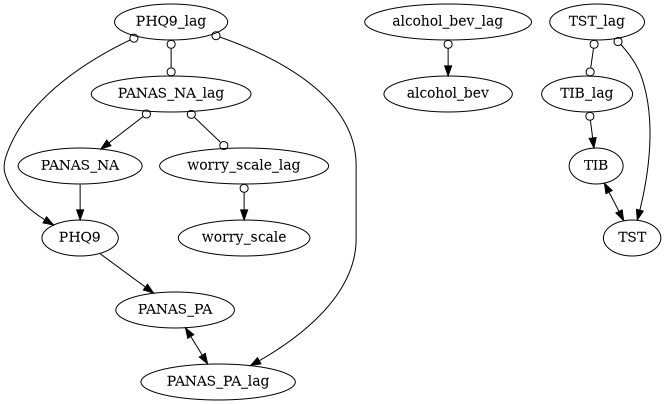

In [9]:
# show the raw graph
obj = DgraphFlex()
# create a list of the edges
edges = list(searchResult['setEdges'])
# add the edges to the graph object
obj.add_edges(edges)
# show the graph
obj.show_graph()

In [10]:
# run the sem

# convert the edges from searchResult to lavaan format
lavaan_model = ts.edges_to_lavaan(edges)
lavaan_model

'PANAS_PA ~ PHQ9\nalcohol_bev ~ alcohol_bev_lag\nPHQ9 ~ PANAS_NA\nPHQ9 ~ PHQ9_lag\nPANAS_NA ~ PANAS_NA_lag\nTIB ~ TIB_lag\nworry_scale ~ worry_scale_lag\nPANAS_PA_lag ~ PHQ9_lag\nTST ~ TST_lag\n'

In [11]:
# run semopy with the lavaan model and the data
sem_results = ts.run_semopy(lavaan_model, df_lag_std)
sem_results

{'opt_res': SolverResult(fun=np.float64(2.6724437974587927), success=np.True_, n_it=23, x=array([-0.47777544,  0.65117731,  0.29076288,  0.66619657,  0.85271809,
         0.48218749,  0.85452818, -0.47869212,  0.40933146,  0.27269897,
         0.77195331,  0.77107072,  0.2125328 ,  0.76768459,  0.83230072,
         0.5759059 ,  0.26963388]), message='Optimization terminated successfully', name_method='SLSQP', name_obj='MLW'),
 'estimates':             lval  op             rval  Estimate  Std. Err    z-value  p-value
 0           PHQ9   ~         PANAS_NA  0.290763  0.023417  12.416768      0.0
 1           PHQ9   ~         PHQ9_lag  0.666197  0.023415  28.451787      0.0
 2       PANAS_NA   ~     PANAS_NA_lag  0.852718  0.020642  41.309860      0.0
 3       PANAS_PA   ~             PHQ9 -0.477775  0.035009 -13.647194      0.0
 4    alcohol_bev   ~  alcohol_bev_lag  0.651177  0.029998  21.707684      0.0
 5            TIB   ~          TIB_lag  0.482187  0.034634  13.922413      0.0
 6  

In [12]:
# the main output we are interested in is the parameter estimates
sem_results['estimates']

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,PHQ9,~,PANAS_NA,0.290763,0.023417,12.416768,0.0
1,PHQ9,~,PHQ9_lag,0.666197,0.023415,28.451787,0.0
2,PANAS_NA,~,PANAS_NA_lag,0.852718,0.020642,41.309860,0.0
3,PANAS_PA,~,PHQ9,-0.477775,0.035009,-13.647194,0.0
4,alcohol_bev,~,alcohol_bev_lag,0.651177,0.029998,21.707684,0.0
5,TIB,~,TIB_lag,0.482187,0.034634,13.922413,0.0
6,worry_scale,~,worry_scale_lag,0.854528,0.020526,41.632179,0.0
7,PANAS_PA_lag,~,PHQ9_lag,-0.478692,0.034710,-13.791108,0.0
8,TST,~,TST_lag,0.409331,0.036062,11.350761,0.0
9,PANAS_NA,~~,PANAS_NA,0.272699,0.015244,17.888544,0.0


In [13]:
# save the graph generated by semopy
# plot into png
png_path = 'pytetrad_plus/boston_data.png'
g = semopy.semplot(sem_results['model'], png_path,  plot_covs = True)


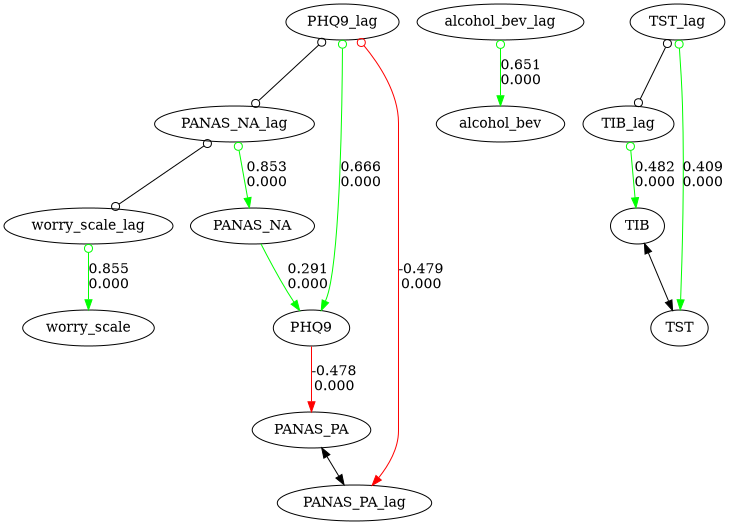

In [14]:
# add the sem results to our graph object

ts.add_sem_results_to_graph(obj, sem_results['estimates'])
# save the graph to a png file
obj.save_graph(plot_format='png', plot_name='boston_graph_single_sem')

# show the graph
obj.show_graph()

In the next section, we perform the stability analysis.

We do 100 runs with a subsample 90% without substitution.

We keep edges that are present at least 75%.

stable_edges contains the edges that were found 75% of the time.

In [19]:
# run the stability search
stable_edges, sorted_edges = ts.run_stability_search(
                                        df, 
                                        model='gfci',
                                        knowledge=knowledge,
                                        score={'sem_bic': {'penalty_discount': 1.0}},
                                        test={'fisher_z': {'alpha': .05}},
                                        runs=100,
                                        min_fraction=0.75,
                                        subsample_fraction=0.9)

stable_edges

Running stability search with 100 runs:   0%|          | 0/100 [00:00<?, ?run/s]


Search complete!


['PANAS_NA --> worry_scale',
 'PHQ9 --> PANAS_PA',
 'TIB_lag o-> TIB',
 'TST_lag o-> TST',
 'alcohol_bev_lag o-> alcohol_bev',
 'PHQ9_lag o-> PHQ9',
 'worry_scale_lag o-> worry_scale',
 'TIB <-> TST',
 'PANAS_PA <-> PANAS_PA_lag',
 'TIB_lag o-o TST_lag']

In [20]:
# lets show the sorted edges
sorted_edges

{'PANAS_NA --> PHQ9': 0.42,
 'PANAS_NA --> worry_scale': 0.94,
 'PANAS_NA <-> PANAS_NA_lag': 0.38,
 'PANAS_NA <-> PHQ9': 0.11,
 'PANAS_NA o-> PHQ9': 0.16,
 'PANAS_NA_lag --> PANAS_NA': 0.16,
 'PANAS_NA_lag --> PHQ9': 0.01,
 'PANAS_NA_lag --> PHQ9_lag': 0.01,
 'PANAS_NA_lag --> worry_scale_lag': 0.27,
 'PANAS_NA_lag <-> PHQ9_lag': 0.08,
 'PANAS_NA_lag o-> PANAS_NA': 0.46,
 'PANAS_NA_lag o-> PHQ9': 0.23,
 'PANAS_NA_lag o-> PHQ9_lag': 0.07,
 'PANAS_NA_lag o-o PHQ9_lag': 0.36,
 'PANAS_NA_lag o-o worry_scale_lag': 0.41,
 'PANAS_PA <-> PANAS_PA_lag': 0.9,
 'PANAS_PA <-> PHQ9': 0.11,
 'PANAS_PA_lag --> PHQ9_lag': 0.01,
 'PANAS_PA_lag --> worry_scale_lag': 0.05,
 'PANAS_PA_lag <-> PANAS_PA': 0.01,
 'PANAS_PA_lag <-> PHQ9_lag': 0.25,
 'PANAS_PA_lag o-> PANAS_PA': 0.09,
 'PANAS_PA_lag o-> PHQ9_lag': 0.06,
 'PANAS_PA_lag o-> worry_scale_lag': 0.02,
 'PHQ9 --> PANAS_NA': 0.18,
 'PHQ9 --> PANAS_PA': 0.89,
 'PHQ9 <-> PANAS_NA': 0.11,
 'PHQ9 <-> PANAS_NA_lag': 0.27,
 'PHQ9 o-> PANAS_NA': 0.02,
 'PHQ9

Let's create a graph of these edges

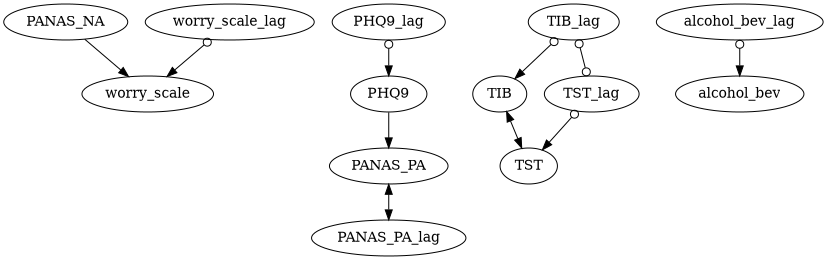

In [21]:
obj = DgraphFlex()
obj.add_edges(stable_edges)
# show the graph
obj.show_graph()

Now that we have the edges, lets run the sem

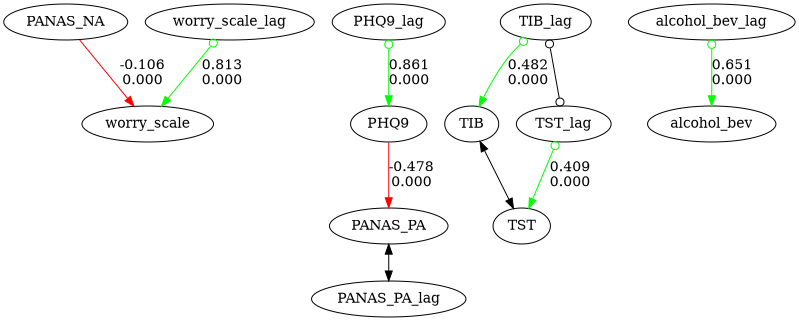

In [22]:
lavaan_model = ts.edges_to_lavaan(stable_edges)

# run semopy, using the lagged and standardized data
sem_results = ts.run_semopy(lavaan_model, df_lag_std)
# add the semopy results to the graph object
ts.add_sem_results_to_graph(obj, sem_results['estimates'])
# save the graph to a png file
obj.save_graph(plot_format='png', plot_name='boston_graph_stable_sem')
# show the graph
obj.show_graph()